In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

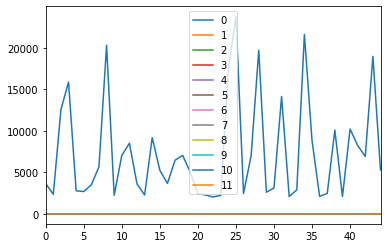

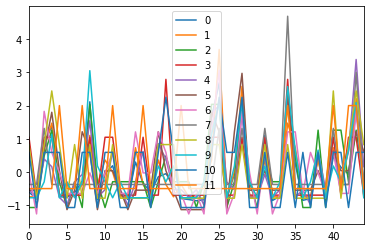

In [2]:
#validate best c on Slide 51

data = np.loadtxt('IAP_PAD2020/tons.dat')
data = pd.DataFrame(data)
data.plot()
plt.show
cols = list(data.columns)
zscore_data_pca = pd.DataFrame()
for col in cols:
        zscore_data_pca[col] = (data[col] - data[col].mean())/data[col].std(ddof=0)
zscore_data_pca.plot()

In [21]:
def center_(x, cluster):
    """ finds the centroid of a cluster
    X - the original data matrix
     cluster - the set with indices of the objects belonging to the cluster
    """
    #number of columns
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = []
        for i in cluster:
            zc.append(zz[i])
        centroidC.append(np.mean(zc))
    return centroidC


def distNorm(x ,remains, ranges, p):
    """ Finds the normalized distances of data points in 'remains' to reference point 'p' 
     X - the original data matrix;
     remains- the set of X-row indices under consideration
     ranges- the vector with ranges of data features 
     p - the data point the distances relate to
     distan- the output column of distances from a to remains """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    distan = di
    return distan


def separCluster(x0, remains, ranges, a, b):
    """  Builds a cluster by splitting the points around refernce point 'a' from those around reference point b 
    x0 - data matrix
    remains- the set of X-row indices under consideration
    ranges- the vector with ranges of data features 
    a, b - the reference points
    cluster - set with row indices of the objects belonging to the cluster  
    """
    
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    cluster = []
    for i in clus:
        cluster.append(remains[i])
    return cluster

def anomalousPattern(x, remains, ranges, centroid, me):
    """ Builds one anomalous cluster based on the algorithm 'Separate/Conquer' (Mirkin, 1999, Machine Learning Journal) 
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
        centroid - initial center of the anomalous cluster being build
        me - vector to shift the 0 (origin) to,
        output: cluster - set of row indices in the anomalous cluster, 
        centroid -center of the cluster    """
        
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
        if  len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ Calculates the normalized distances of data points in 'remains' to reference point 'p'   
        X - data matrix,
        remains - set of its row indices (objects) under consideration,
        ranges - normalizing values: the vector with ranges of data features  
    
       distan - the calculated normalized distances
    """

    #number of columns
    mm = x.shape[1]
    rr = len(remains)
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j]
        z = z.reshape((-1,1))
        zz = z[remains]
        y = zz - p[j]
        y = y / ranges[j]
        y = np.array(y)
        yy = y * y
        distan = distan + yy
    return distan

def zscore(df):
    for col in list(df.columns):
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)
    return df

def init_data(which='air'):
    if which=='town':
        pass
    if which=='air':
        df = pd.read_csv('data_selection.csv')
        return zscore(df.iloc[:,5:])
    if which=='2d':
        df = pd.read_csv('data_selection.csv')
        return zscore(df.iloc[:,7:9])


In [22]:
##### ****** Main body for the Iterative Anomalous Cluster   *****
#### You should test and Validate it with Market Towns Data set    
# normalization FLAG
normalization = 0
# threshold value (this is an example)
threshold = 7

### I consider this from the PCA transformation

data_ap =  init_data('2d')# pandas dataframe
print(data_ap.head())
#data_ap =  zscore_data_pca.iloc[:,:-1]# pandas dataframe 
x = data_ap.values.astype(np.float32)
#y = data.target
#number of data points
nn = x.shape[0]
#number of features
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    # use each row of the feature
    z = x[:, j]
    # add the mean to list of means
    me.append(np.mean(z))
    #add max to list of maxs
    mmax.append(np.max(z))
    #add min to list of mins
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1);
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
#standard error
sY = np.array(sy)
# sum of standard deviation?
d = np.sum(sY * sY)   # total data scatter of normalized data


# x, me range, d
remains = list(range(nn))  # current index set of residual data after some anomalous clusters are extracted
numberC = 0; # anomalous cluster counter
while(len(remains) != 0):
    distance = dist(x, remains, ranges, me) # finding normalised distance vector from remains data points to reference 'me'
    ind = np.argmax(distance)
    index = remains[ind]
    centroid = x[index, :] # initial anomalous center reference point
    numberC = numberC + 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me) # finding AP cluster
    
    
    censtand = np.divide((np.asarray(centroid) - me), np.asarray(ranges)) # standardised centroid   
    dD = np.sum(np.divide(censtand * censtand.T * len(cluster) * 100, d))   # cluster contribution, per cent 

    remains = np.setdiff1d(remains, cluster) 
    # update the data structure that keeps everything together
    ancl.append(cluster)   # set of data points in the cluster
    ancl.append(censtand)  # standardised centroid
    ancl.append(dD) # proportion of the data scatter
    
ancl = np.asarray(ancl)
ancl = ancl.reshape((numberC, 3))
##aK = numberC
b = 3
ll = [] # list of clusters

for ik in range(numberC):
    ll.append(len(ancl[ik, 0]))
    
rl = [i for i in ll if i >= threshold] # list of clusters with at least threshold elements
cent = []
if(len(rl) == 0):
    print('Too great a threhsold!!!')
else:
    print('number of clusters: ', len(rl))
    num_cents = 0
    for ik in range(numberC):
        cluster = ancl[ik,0]
        if(len(cluster) >= threshold):
            cent.append(ancl[ik, 1])
            num_cents += 1
                
cent = np.asarray(cent)
### Should be adapted
cent = cent.reshape((len(cent), len(zscore_data_pca.columns) - 1))
print("Initial prototypes: \n", np.round(cent, 5))

init_partition = np.zeros((zscore_data_pca.shape[0], len(cent)))
for index, d in enumerate(zscore_data_pca):
    dists = [np.linalg.norm(d - c) for c in cent]
    assign = dists.index(np.min(dists))
    init_partition[index, assign] = 1



        SO2       NO2
0 -0.615605  1.202690
1 -0.662852  1.025913
2 -0.662852  0.981719
3 -0.710099  0.937525
4 -0.521110  1.246884
number of clusters:  9


ValueError: cannot reshape array of size 18 into shape (9,11)

In [24]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#Here comes the fuzzy clustering!#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# First of all, we need to define our constraints and such
def constraint_membership(arr):
    for row in range(arr.shape[0]):
        if np.sum(arr[row,:]) != 1:
            return false
    return True

# Matrix X (the fuzzy c-partition) consists of each data point in a cluster
# and their membership value which is contained in [0,1]
# which means we have a cxn matrix of k-tuples
# where k is the number of attributes our dataset has
# (I THINK)

# Secondly, we will define the parameters
# number of clusters (renamed from sample code)
num_clusters = num_cents
# weighting exponent (Degree of fuzzification) m >=1.0 where 1.0 means crisp
m = 2.0
# maximum number of iterations T, arbitrarily capped at 100
T = 100
#Termination measure? E_t = norm(V_t -V_(t-1)) 
#!!! V_t is a set of vectors of prototypes or centroids after t iterations



**a)** 

- Study the fuzzy c-means (FCM) program in the software package of your choice.
- Apply the program to your dataset at the same c parameter with random seeds. Do this for several different values of parameter c= c_min, ..., c_max. Plot the FCM cost function versus c.

- Analyse the graphic and comment if any number of clusters better fits your data than the others.

2
[[0.32530895 0.37632988 0.38765842 ... 0.82789433 0.52162091 0.66142233]
 [0.67469105 0.62367012 0.61234158 ... 0.17210567 0.47837909 0.33857767]]
3
[[0.7935997  0.80184017 0.80507924 ... 0.4714169  0.84678653 0.71010792]
 [0.12167209 0.12663039 0.12667281 ... 0.47575599 0.11613506 0.239195  ]
 [0.08472821 0.07152944 0.06824795 ... 0.05282711 0.03707841 0.05069708]]
4
[[0.37639253 0.45310653 0.47285079 ... 0.70403362 0.82271286 0.79948736]
 [0.05021396 0.04624814 0.04480699 ... 0.02018422 0.01555007 0.01716468]
 [0.4807961  0.39705159 0.37744577 ... 0.08024788 0.102983   0.08956005]
 [0.09259742 0.10359374 0.10489646 ... 0.19553428 0.05875407 0.09378791]]
5
[[0.09514314 0.16841915 0.1894455  ... 0.80790476 0.65297991 0.74940639]
 [0.79829767 0.67893095 0.64820284 ... 0.05164101 0.18303034 0.10609021]
 [0.01337988 0.01811309 0.01894629 ... 0.00882559 0.01508623 0.01201189]
 [0.02957543 0.04831917 0.0527588  ... 0.09473271 0.06685106 0.07535021]
 [0.06360388 0.08621765 0.09064658 ... 0

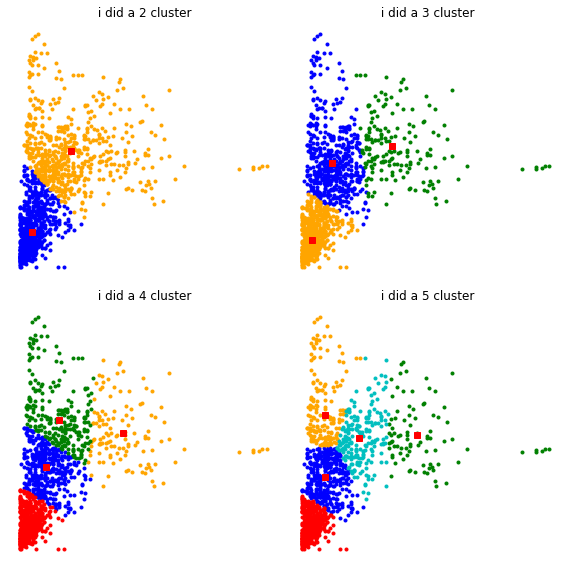

In [28]:
from __future__ import division, print_function
import skfuzzy as fuzz
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
# whatever may this number mean?
np.random.seed(28980)
fig1, axes1 = plt.subplots(2,2, figsize=(8,8))
alldata = np.vstack((data_ap.iloc[:,0],data_ap.iloc[:,1]))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    print(ncenters)
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=100, init=None)
    
    #store fpc values for later
    fpcs.append(fpc)
    
    #plot assigned clusters, for each data point in set
    print(u)
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(data_ap.iloc[:,0][cluster_membership == j],
               data_ap.iloc[:,1][cluster_membership == j],
               '.', color=colors[j])
    
    #mark center of each cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')
        
    ax.set_title(' i did a {} cluster'.format(ncenters))
    ax.axis('off')
    
fig1.tight_layout()
print(fpcs)

**b)**
- Study the Anomalous Pattern (AP) clustering algorithm. 
- Test the implementation with the benchmark data sets provided to you.

**c)** 
- Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the Anomalous Patterns_FCM (AP-FCM) to your data set.
- Discuss the options taken for setting the AP parameters. Present and visualize the found fuzzy partitions of AP-FCM.

**d)**
- Discuss the results obtained by Anomalous Patterns FCM for your data case respecting the following: 
    - (i) location of the initial prototypes
    - (ii) choice of the number of clusters.

**e)**
- Apply, at least, two validation indices, like the *Adjust Rand Index (ARI)* and *Xie-Beni*, to access the quality of the fuzzy c-partitions obtained in **a)**. 
- Compare these results with the one of Anomalous Patterns FCM getting in **c)**.

**f)**
- Make an interpretation of the found clusters by the AnomalousPatterns_FCM for your data as discussed in the classes.